# CS 543 Final Project: Grading of Diabetic Retinopathy Severity Level

## Hongshuo Wang

In [1]:
import os
import numpy as np
from PIL import Image
import warnings
from multiprocessing import Pool
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
from PIL import Image, ImageOps
import PIL
import cv2
import pandas as pd

In [2]:
# References:

# https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy#3.A-Important-Update-on-Color-Version-of-Cropping-&-Ben's-Preprocessing
# https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Kaggles/DiabeticRetinopathy/train.py



# Generate training vs testing vs validation set

df = pd.read_csv('data/trainLabels_cropped.csv')

y = df[['image','level']]
SEED = 99

y = shuffle(y, random_state=SEED)

train_y, valid_y = train_test_split(y, test_size=0.3)
valid_y, test_y = train_test_split(valid_y, test_size=1.0/3.0)

train_y.shape, valid_y.shape, test_y.shape

print(train_y['level'].value_counts())
print(valid_y['level'].value_counts())

train_y['level'].hist()
valid_y['level'].hist()

print(test_y['level'].value_counts())
test_y['level'].hist()

train_y.to_csv('train_cropped.csv', index=False)

valid_y.to_csv('val_cropped.csv', index=False)

test_y.to_csv('test_cropped.csv', index=False) 



# Data Preprocessing

In [3]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [4]:
def load_ben_color(img, sigmaX=10):
    image = img
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [5]:
def trim(im):
    """
    Converts image to grayscale using cv2, then computes binary matrix
    of the pixels that are above a certain threshold, then takes out
    the first row where a certain percetage of the pixels are above the
    threshold will be the first clip point. Same idea for col, max row, max col.
    """
    percentage = 0.02

    img = np.array(im)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    im = img_gray > 0.1 * np.mean(img_gray[img_gray != 0])
    row_sums = np.sum(im, axis=1)
    col_sums = np.sum(im, axis=0)
    rows = np.where(row_sums > img.shape[1] * percentage)[0]
    cols = np.where(col_sums > img.shape[0] * percentage)[0]
    min_row, min_col = np.min(rows), np.min(cols)
    max_row, max_col = np.max(rows), np.max(cols)
    im_crop = img[min_row : max_row + 1, min_col : max_col + 1]
    return Image.fromarray(im_crop)

def resize_maintain_aspect(image, desired_size):
    """
    Stole this from some stackoverflow post but can't remember which,
    this will add padding to maintain the aspect ratio.
    """
    old_size = image.size  # old_size[0] is in (width, height) format
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    im = image.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size - new_size[0]) // 2, (desired_size - new_size[1]) // 2))
    return new_im

def save_single(args):
    img_file, input_path_folder, output_path_folder, output_size = args
    image_original = Image.open(os.path.join(input_path_folder, img_file))
    image = trim(image_original)
    image = resize_maintain_aspect(image, desired_size=output_size[0])
    image = load_ben_color(image,10)
    image.save(os.path.join(output_path_folder + img_file))
    
def fast_image_resize(input_path_folder, output_path_folder, output_size=None):
    """
    Uses multiprocessing to make it fast
    """
    if not output_size:
        warnings.warn("Need to specify output_size! For example: output_size=100")
        exit()

    if not os.path.exists(output_path_folder):
        os.makedirs(output_path_folder)

    jobs = [
        (file, input_path_folder, output_path_folder, output_size)
        for file in os.listdir(input_path_folder)
    ]

    with Pool() as p:
        list(tqdm(p.imap_unordered(save_single, jobs), total=len(jobs)))
        
        
        


In [6]:
#fast_image_resize("data\\aptos2019-blindness-detection\\train_images\\", "data\\aptos2019-blindness-detection\\train\\images_resized_512\\", output_size=(512, 512))
#fast_image_resize("data\\aptos2019-blindness-detection\\test_images\\", "data\\aptos2019-blindness-detection\\test\\images_resized_512\\", output_size=(512, 512))

In [7]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy as np
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from utils import save_checkpoint, load_checkpoint, check_accuracy
from sklearn.metrics import cohen_kappa_score
import os
import pandas as pd
from efficientnet_pytorch import EfficientNet
from PIL import Image
from sklearn.metrics import cohen_kappa_score
import torch.nn.functional as F



In [8]:
# Hyperperameter


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 10
NUM_EPOCHS = 100
NUM_WORKERS = 6
CHECKPOINT_FILE = "b3.pth.tar"
PIN_MEMORY = True
SAVE_MODEL = True
LOAD_MODEL = True

# Data augmentation for images
input_size = 512

train_transforms = A.Compose(
    [
        A.Resize(width=input_size, height=input_size),
        A.RandomCrop(height=input_size-20, width=input_size-20),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Blur(p=0.3),
        A.CLAHE(p=0.3),
        A.ColorJitter(p=0.3),
        A.CoarseDropout(max_holes=12, max_height=20, max_width=20, p=0.3),
        A.IAAAffine(shear=30, rotate=0, p=0.2, mode="constant"),
        A.Normalize(
            mean=[0.3199, 0.2240, 0.1609],
            std=[0.3020, 0.2183, 0.1741],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=input_size-20, width=input_size-20),
        A.Normalize(
            mean=[0.3199, 0.2240, 0.1609],
            std=[0.3020, 0.2183, 0.1741],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)




# Dataset

In [9]:
class DRDataset(Dataset):
    def __init__(self, images_folder, path_to_csv, train=True, transform=None):
        super().__init__()
        self.data = pd.read_csv(path_to_csv)
        self.images_folder = images_folder
        self.image_files = os.listdir(images_folder)
        self.transform = transform
        self.train = train

    def __len__(self):
        return self.data.shape[0] #if self.train else len(self.image_files)

    def __getitem__(self, index):
        if self.train:
            image_file, label = self.data.iloc[index]
        else:
            # if test simply return -1 for label, I do this in order to
            # re-use same dataset class for test set submission later on
            image_file, label = self.data.iloc[index]
            image_file = image_file.replace(".jpeg", "")

        image = np.array(Image.open(os.path.join(self.images_folder, image_file+".jpeg")))

        if self.transform:
            
            image = self.transform(image=image)["image"]

        return image, label, image_file

# Training 

In [10]:
def make_prediction(model, loader, output_csv="submission.csv"):
    preds = []
    filenames = []
    model.eval()

    for x, y, files in tqdm(loader):
        x = x.to(DEVICE)
        with torch.no_grad():
            predictions = model(x)
            # Convert MSE floats to integer predictions
            predictions[predictions < 0.5] = 0
            predictions[(predictions >= 0.5) & (predictions < 1.5)] = 1
            predictions[(predictions >= 1.5) & (predictions < 2.5)] = 2
            predictions[(predictions >= 2.5) & (predictions < 3.5)] = 3
            predictions[(predictions >= 3.5) & (predictions < 10000000)] = 4
            predictions = predictions.long().squeeze(1)
            preds.append(predictions.cpu().numpy())
            filenames += files

    #df = pd.DataFrame({"image": filenames, "level": np.concatenate(preds, axis=0)})
    df = pd.DataFrame({"image": filenames, "level": np.concatenate(preds, axis=0)})
    df.to_csv(output_csv, index=False)
    model.train()
    print("Done with predictions")


def check_accuracy(loader, model, device="cuda"):
    model.eval()
    all_preds, all_labels = [], []
    num_correct = 0
    num_samples = 0

    for x, y, filename in tqdm(loader):
        x = x.to(device=device)
        y = y.to(device=device)

        with torch.no_grad():
            predictions = model(x)

        # Convert MSE floats to integer predictions
        predictions[predictions < 0.5] = 0
        predictions[(predictions >= 0.5) & (predictions < 1.5)] = 1
        predictions[(predictions >= 1.5) & (predictions < 2.5)] = 2
        predictions[(predictions >= 2.5) & (predictions < 3.5)] = 3
        predictions[(predictions >= 3.5) & (predictions < 100)] = 4
        predictions = predictions.long().view(-1)
        y = y.view(-1)

        num_correct += (predictions == y).sum()
        num_samples += predictions.shape[0]

        # add to lists
        all_preds.append(predictions.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())

    print(
        f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
    )
    model.train()
    return np.concatenate(all_preds, axis=0, dtype=np.int64), np.concatenate(
        all_labels, axis=0, dtype=np.int64
    )


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer, lr):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    model.eval()

def train_one_epoch(loader, model, optimizer, loss_fn, scaler, device):
    losses = []
    loop = tqdm(loader)
    for batch_idx, (data, targets, _) in enumerate(loop):
        # save examples and make sure they look ok with the data augmentation,
        # tip is to first set mean=[0,0,0], std=[1,1,1] so they look "normal"
        #save_image(data, f"hi_{batch_idx}.png")

        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        with torch.cuda.amp.autocast():
            scores = model(data)
            loss = loss_fn(scores, targets.unsqueeze(1).float())

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss=loss.item())

    print(f"Loss average over epoch: {sum(losses)/len(losses)}")
    
    
    
    
    
    

train_ds = DRDataset(
    #images_folder="train/images_preprocessed_1000/",
    #path_to_csv="train/trainLabels.csv",

    images_folder="data/resized_train/resized_train_300/",
    path_to_csv="train_cropped.csv",

    transform=config.train_transforms,
)
val_ds = DRDataset(
    images_folder="data/resized_train/resized_train_300/",
    path_to_csv="val_cropped.csv",
    transform=config.val_transforms,
)
test_ds = DRDataset(
    images_folder="data/resized_train/resized_train_300/",
    path_to_csv="test_cropped.csv",
    transform=config.val_transforms,
    train=False,
)
test_loader = DataLoader(
    test_ds, batch_size=config.BATCH_SIZE, num_workers=6, shuffle=False
)
train_loader = DataLoader(
    train_ds,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY,
    shuffle=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=config.BATCH_SIZE,
    num_workers=2,
    pin_memory=config.PIN_MEMORY,
    shuffle=True,
)
loss_fn = nn.MSELoss()

model = EfficientNet.from_pretrained("efficientnet-b3")
model._fc = nn.Linear(1536, 1)
model = model.to(config.DEVICE)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

if config.LOAD_MODEL and config.CHECKPOINT_FILE in os.listdir():
    load_checkpoint(torch.load(config.CHECKPOINT_FILE), model, optimizer, config.LEARNING_RATE)

# Run after training is done and you've achieved good result
# on validation set, then run train_blend.py file to use information
# about both eyes concatenated
#get_csv_for_blend(val_loader, model, "data/aptos2019-blindness-detection/val_blend.csv")
#get_csv_for_blend(train_loader, model, "data/aptos2019-blindness-detection/train_blend.csv")
#get_csv_for_blend(test_loader, model, "data/aptos2019-blindness-detection/test_blend.csv")
#make_prediction(model, test_loader, "submission_.csv")
#import sys
#sys.exit()
#make_prediction(model, test_loader)

for epoch in range(config.NUM_EPOCHS):
    train_one_epoch(train_loader, model, optimizer, loss_fn, scaler, config.DEVICE)

    # get on validation
    preds, labels = check_accuracy(val_loader, model, config.DEVICE)
    print(f"QuadraticWeightedKappa (Validation): {cohen_kappa_score(labels, preds, weights='quadratic')}")

    # get on train
    preds, labels = check_accuracy(train_loader, model, config.DEVICE)
    print(f"QuadraticWeightedKappa (Training): {cohen_kappa_score(labels, preds, weights='quadratic')}")

    if config.SAVE_MODEL:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=f"checkpoints/test 1/b3_{epoch}.pth.tar")

make_prediction(model, test_loader)

# Loading pretrained model 

In [11]:
CHECKPOINT_FILE = "checkpoints/test 512/b3_18.pth.tar"
LOAD_MODEL = True
loss_fn = nn.MSELoss()


model = EfficientNet.from_pretrained("efficientnet-b3")
model._fc = nn.Linear(1536, 1)
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()


load_checkpoint(torch.load(CHECKPOINT_FILE), model, optimizer, LEARNING_RATE)

Loaded pretrained weights for efficientnet-b3
=> Loading checkpoint


# Prediction

In [12]:
def make_prediction(model, loader, output_csv="submission.csv"):
    preds = []
    filenames = []
    model.eval()

    for x, y, files in tqdm(loader):
        x = x.to(DEVICE)
        with torch.no_grad():
            predictions = model(x)
            # Convert MSE floats to integer predictions
            predictions[predictions < 0.5] = 0
            predictions[(predictions >= 0.5) & (predictions < 1.5)] = 1
            predictions[(predictions >= 1.5) & (predictions < 2.5)] = 2
            predictions[(predictions >= 2.5) & (predictions < 3.5)] = 3
            predictions[(predictions >= 3.5) & (predictions < 10000000)] = 4
            predictions = predictions.long().squeeze(1)
            preds.append(predictions.cpu().numpy())
            filenames += files

    #df = pd.DataFrame({"image": filenames, "level": np.concatenate(preds, axis=0)})
    df = pd.DataFrame({"image": filenames, "level": np.concatenate(preds, axis=0)})
    df.to_csv(output_csv, index=False)
    #model.train()
    print("Done with predictions")
    
    return filenames, preds

In [13]:
test_ds = DRDataset(
    images_folder="data/resized_train/resized_train_512/",
    path_to_csv="test_cropped.csv",
    transform=val_transforms,
    train=False,
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, num_workers=0, shuffle=False
)

filesnames, preds = make_prediction(model, test_loader,output_csv="output/f_submission.csv")

100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [01:05<00:00,  5.41it/s]

Done with predictions


In [14]:
len(filesnames)

3511

In [15]:
len(test_loader)

352

In [16]:
test_ds.train

False

In [17]:
len(test_ds)

3511

In [18]:
output_y = pd.read_csv('output/f_submission.csv')
true_y = pd.read_csv('test_cropped.csv')

In [19]:
output_y.head()

,image,level
0,5316_right,0
1,25596_right,0
2,32373_right,0
3,31827_right,0
4,21_right,0


In [20]:
true_y.head()

,image,level
0,5316_right,0
1,25596_right,0
2,32373_right,0
3,31827_right,0
4,21_right,0


In [21]:
print(true_y.shape)

(3511, 2)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from prettytable import PrettyTable
# Test model using test dataset

import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def test(true_y, output_y):
    
    
    test = true_y["level"].values
    pred = output_y["level"].values
    #Confusion Matrix
    print(" ")
    matrix = metrics.confusion_matrix(test, pred)
    print(" ")
    print('vgg_Confusion_Matrix:')
    print(" ")
    print(matrix)
    print(" ")
    
    print("classification_report: ")
    print('-'*40)
    print(metrics.classification_report(test, pred))
    
    print(f"QuadraticWeightedKappa (test): {cohen_kappa_score(test, pred, weights='quadratic')}")
   
    
    # Plotting ROC curve
    # Binarize the output
    
    
    
    
    y_test = label_binarize(true_y["level"].values, classes=[0, 1, 2, 3, 4])
    y_pred = label_binarize(output_y["level"].values, classes=[0, 1, 2, 3, 4])
    n_classes = y_pred.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC for specific class
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to specific class: class = 0')
    plt.legend(loc="lower right")
    plt.show()
    
    print(' ')
    
    # Plot ROC curve for multi class
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
print("Model is ready to Test")

Model is ready to Test


In [23]:
true_y["level"].values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

 
 
vgg_Confusion_Matrix:
 
[[2472  142   18    1    0]
 [ 152   60   14    0    0]
 [ 106  139  245   21    0]
 [   3    4   40   26    3]
 [   0    3   18   30   14]]
 
classification_report: 
----------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2633
           1       0.17      0.27      0.21       226
           2       0.73      0.48      0.58       511
           3       0.33      0.34      0.34        76
           4       0.82      0.22      0.34        65

    accuracy                           0.80      3511
   macro avg       0.59      0.45      0.48      3511
weighted avg       0.82      0.80      0.80      3511

QuadraticWeightedKappa (test): 0.7779714189838315


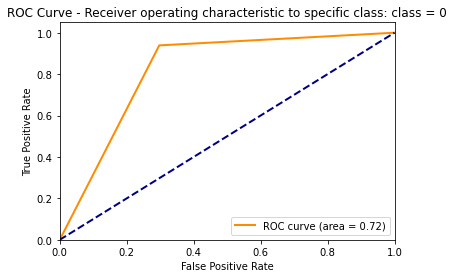

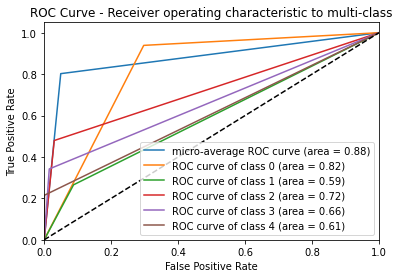

In [24]:
test(true_y, output_y)